# Connectivity Inference V2

This notebook applied the V2 of the connectivity inference on the adEx implementation of Taehoon of "Susin, Eduarda, and Alain Destexhe. 2021."

In [1]:
############################
######## SETUP  ###########

#####  General Imports ######
import numpy as np
from brian2 import *
from matplotlib import pyplot
import sys
import networkx

##### setup interactive ####
%matplotlib notebook 

In [2]:
#### Simulation Scripts #####
sys.path.append('../simulations/')
from wp2_adex_model_script import * 

###### Utility Scripts #####
sys.path.append('../tools')
import adEx_util as  adEx_util

In [3]:
###########################
####### RUN SIMULATION ####

### choose parameters ###
params = dict()
params['sim_time'] = float(30) # simulation time in seconds 
params['a'] = float( 4*10**(-9))    # subthreshold adaption constant [Siemens]
params['b'] = float(0.0805 * 10**(-9)) # spike-triggert adaption constant [A ]
params['N'] = int(10) #  no of neurons
params['ge']=float(4) # excitatory synaptic conductance [nS ??] - [VALUE ???]
params['gi']=float(4) # inhibitory synaptic conductance [nS ??] - [VALUE ???]

root_dir = 'simData'

curr_dir = root_dir + '/' + str(params['N'])

#if(not(os.path.exists(curr_dir))):
#    os.makedirs(curr_dir)

params['save_fol'] = curr_dir


# run simulation
#trace, spikes, S = simpleNetV2(n, p, c, t, ws, tauw, a, b, Vr) # Regular spiking 
result = run_sim(params)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.09s). [brian2.stateupdaters.base.method_choice]


The time difference is : 35.043039243
[ 12.1  14.3  17.   17.9  18.1  18.2  18.2  18.3  23.2  23.6  26.3  27.8
  28.3  28.5  28.5  28.7  32.7  34.   36.8  49.1  49.5  49.7  49.7  49.9
  51.7  54.7  55.7  61.5  61.9  62.1  62.1  62.3  63.   70.8  71.7  75.4
  76.1  76.3  76.3  76.3  76.4  81.2  82.   86.   88.1  88.2  88.2  88.2
  88.2  92.6  93.3  96.8 100.7 100.8 100.8 100.8 100.8]
[ 2.2  9.4 15.3 15.5 20.3 20.5 22.5 28.7 28.9 31.8 46.8 47.1 52.4 55.9
 58.3 67.5 68.5 73.2 75.2 76.4 80.3 84.9 86.3 90.5 95.  97.6]
simulation successfullly ran for 10_4e-09_8.05e-11_30.0_4.0_4.0


<IPython.core.display.Javascript object>


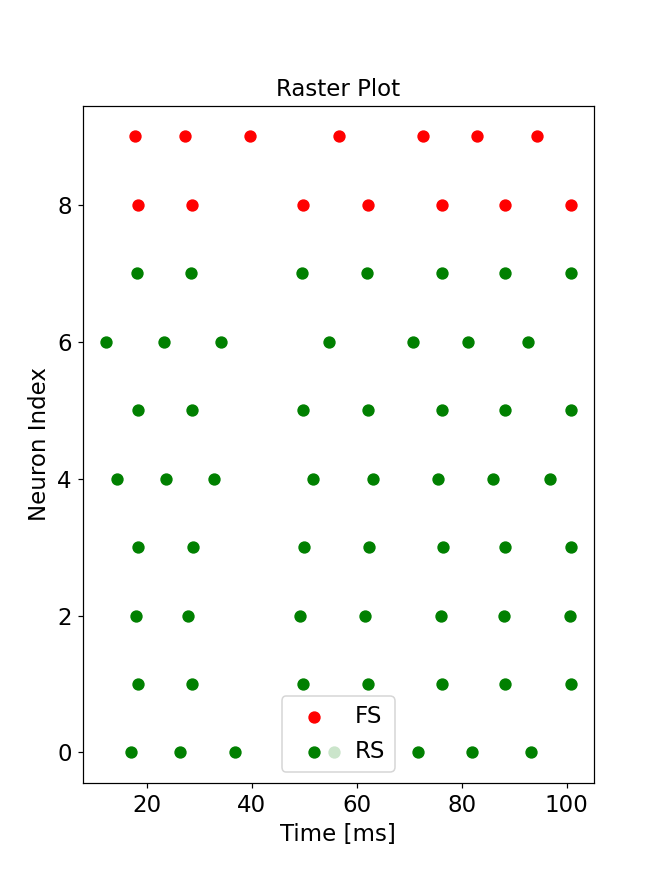

<IPython.core.display.Javascript object>


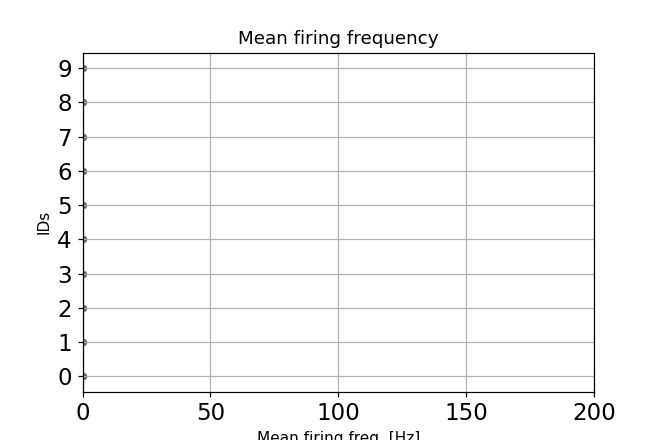

In [4]:
###########################
####### SHOW DATA #########

##### raster plot
Fig=plt.figure(figsize=(6,8))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


figa=Fig.add_subplot()
plt.title('Raster Plot', fontsize=15)
plt.scatter(  result['in_time'], result['in_idx'], color='red',s=50,label="FS")
plt.scatter(  result['ex_time'], result['ex_idx'], color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Neuron Index', fontsize=15) 

##### mean fireing freq.
fig = pyplot.figure(figsize=(6,4))

index, counts = np.unique( result['ex_idx'], return_counts=True)
pyplot.scatter(counts/1000, index , s=15, c=[[.4,.4,.4]], label="RS")

index, counts = np.unique(result['in_idx'], return_counts=True)
pyplot.scatter(counts/1000, index , s=15, c=[[.4,.4,.4]], label="FS")


pyplot.yticks(np.arange(0,result['NI']+result['NE'], 1)) # tick every 1 neuron(s)
pyplot.xlim([0,200])
pyplot.ylabel('IDs')
pyplot.xlabel('Mean firing freq. [Hz]')
pyplot.title('Mean firing frequency')
pyplot.grid()
pyplot.show()

In [5]:
#############################
##### Unpack data ###########
# unpack spikes
times=numpy.append( result['in_time'],  result['ex_time']) # [s]
ids=numpy.append(result['in_idx'],  result['ex_idx'])  
nodes=numpy.arange(0, params['N'], 1)

In [6]:
#############################
###### Infer. Fn. Conn ######

#Note: Conncectvity can only be inferred for the neurons that have at least one spike.
#      Neurons of no single spike are not shown in the graph.

# conversions fom Brain2 --> sPYcon
times_in_sec = (times) /1000 # convert to unitless times from [ms] -> [s]

# import inference method
sys.path.append('../tools/spycon/src')
from sci_sccg import Smoothed_CCG

# define inference method
coninf = Smoothed_CCG() # English2017

# get ground truth graph of network
marked_edges, nodes = adEx_util.make_marked_edges_TwoGroups(ids,result['conn_ee'], result['conn_ei'], result['conn_ii'], result['conn_ie'])

### get conncectivity test 
from spycon_tests import load_test, ConnectivityTest
# define test
spycon_test = ConnectivityTest("spycon_test",times_in_sec, ids, nodes, marked_edges)
# run test
spycon_result, test_metrics = spycon_test.run_test(coninf, only_metrics=False, parallel=True,)

71


<IPython.core.display.Javascript object>


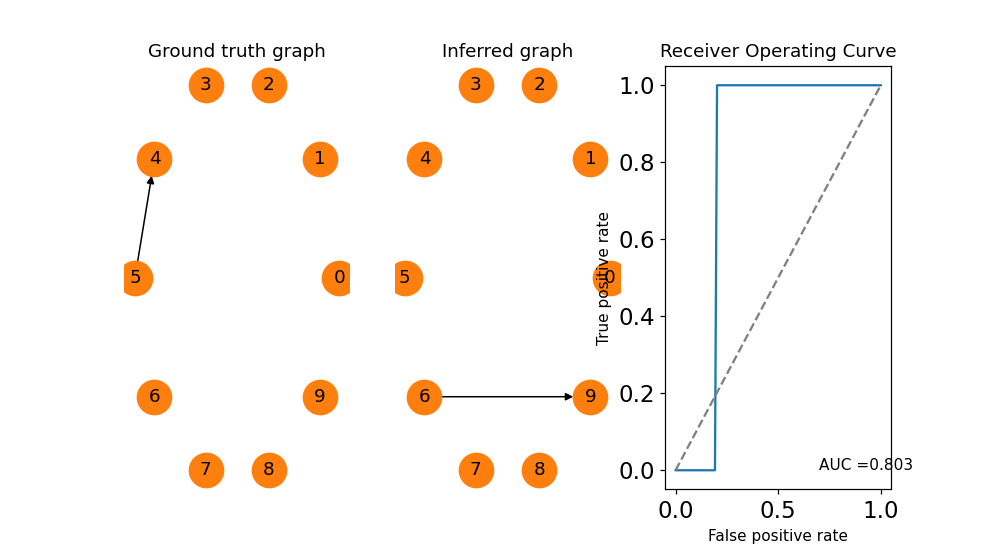

In [8]:
fig = pyplot.figure(figsize=(9,5))
ax1 = fig.add_subplot(131)
spycon_test.draw_graph()
pyplot.title('Ground truth graph')
ax2 = fig.add_subplot(132)
spycon_result.draw_graph(graph_type='binary', ax=ax2)
pyplot.title('Inferred graph')
ax3 = fig.add_subplot(133)
fpr, tpr, auc = tuple(test_metrics[['fpr', 'tpr', 'auc']].to_numpy()[0])
pyplot.plot(fpr, tpr)
pyplot.plot([0,1],[0,1], color='gray', linestyle='--')
pyplot.text(.7,.0,'AUC =%.3f' %auc)
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('Receiver Operating Curve')
pyplot.show()

<IPython.core.display.Javascript object>


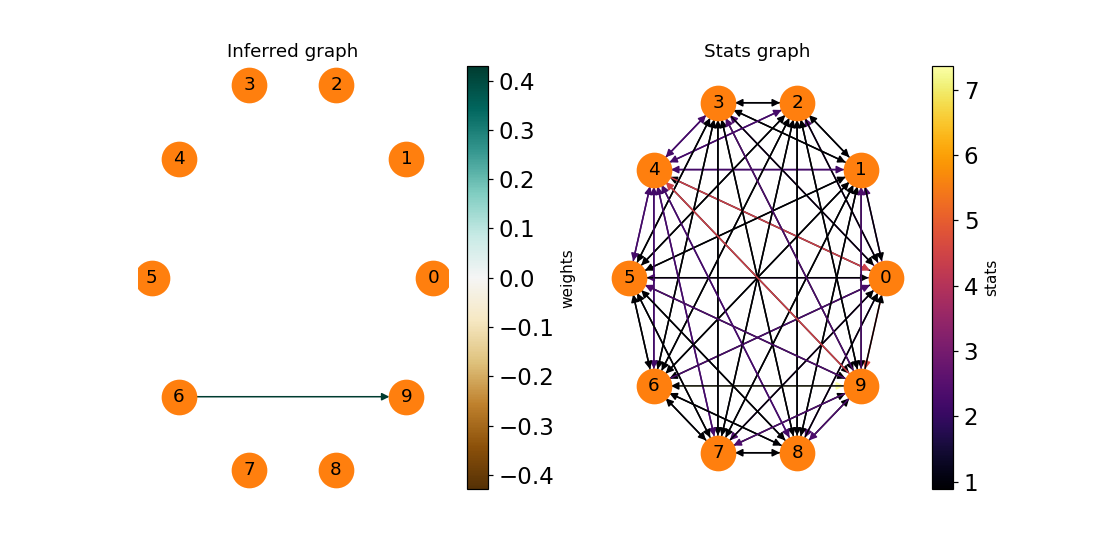

In [9]:
fig = pyplot.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
spycon_result.draw_graph(graph_type='weighted', ax=ax1)
ax1.set_title('Inferred graph')
ax2 = fig.add_subplot(122)
spycon_result.draw_graph(graph_type='stats', ax=ax2)
ax2.set_title('Stats graph')
pyplot.show()

In [10]:
###############################
###### Cross-Correlation ######

# Adding Cross-Correlation methods from "Methods_Viz" from Christian's code
# Needs to work through properly !!

def visualization_english(Smoothed_CCG, times1: numpy.ndarray, times2: numpy.ndarray,
                  t_start: float, t_stop: float) -> (numpy.ndarray):

    kernel = Smoothed_CCG.partially_hollow_gauss_kernel()
    counts_ccg, counts_ccg_convolved, times_ccg = Smoothed_CCG.compute_ccg(times1, times2, kernel, t_start, t_stop)
    
    return counts_ccg, counts_ccg_convolved, times_ccg 

Note the default params of Smoothed_CCG -> especially the binsize

```python
default_params = {'binsize': .4e-3,
                               'hf': .6,
                               'gauss_std': 0.01,
                               'syn_window': (.8e-3,2.8e-3),
                               'ccg_tau': 20e-3,
                               'alpha': .01}
```

Taehoon recommended to use 0.5ms to 1ms as a bin size. Need to fix parameters first.

<IPython.core.display.Javascript object>


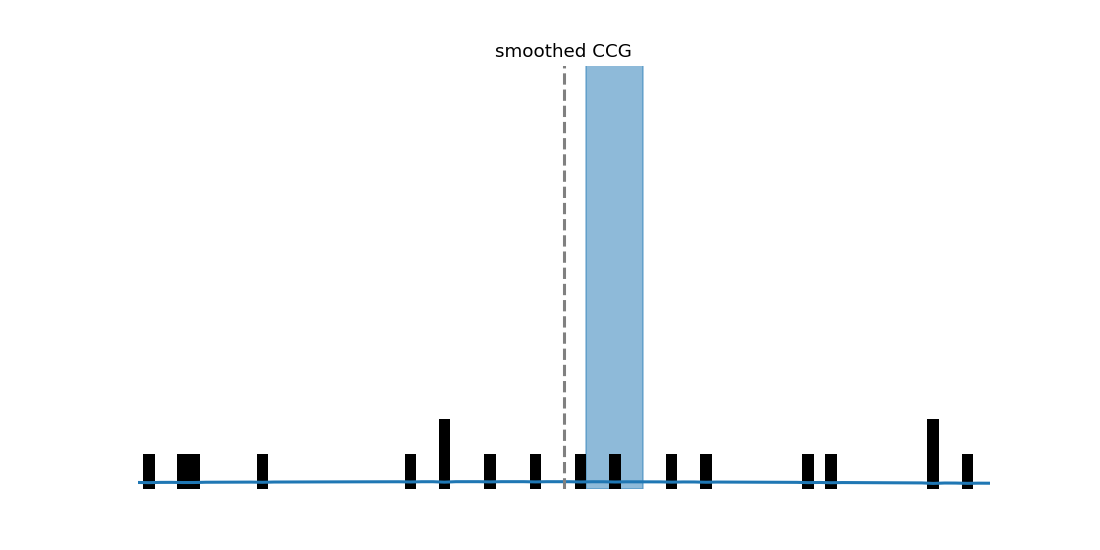

Text(0.5, 1.0, 'smoothed CCG')

In [15]:
## get edges and ids
edges = numpy.where(numpy.logical_and(spycon_test.marked_edges[:,2] != 0, numpy.logical_not(numpy.isnan(spycon_test.marked_edges[:,2]))))[0]
idx = 0
id1, id2 = spycon_test.marked_edges[edges[idx],:2]

## run corr correlation 
times1, times2 = spycon_test.times[spycon_test.ids == id1], spycon_test.times[spycon_test.ids == id2]
counts_ccg, counts_ccg_convolved, times_ccg = visualization_english(coninf, times1, times2, 0, 3600)

# plot
fig = pyplot.figure(figsize=(10,5))
ax = pyplot.subplot(111)
ax.axis('off')
ax.fill_between([coninf.default_params['syn_window'][0] * 1e3, coninf.default_params['syn_window'][1] * 1e3], 0, numpy.amax(counts_ccg) + 20, color='C0', alpha=.5)
ax.bar(times_ccg * 1e3, counts_ccg, width=coninf.default_params['binsize'] * 1e3, color='k', label='Data CCG')
ax.plot(times_ccg * 1e3, counts_ccg_convolved, 'C0', label='Smoothed CCG', lw=2)
ax.vlines([0], 0, numpy.amax(counts_ccg) + 20, lw=2, ls='--', color='gray')
ax.hlines(40,-12,-8, 'k')
ax.text(-11, 47, '5 ms')
#ax.legend()
ax.set_xlim([-15,15])
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Spike count')
ax.set_ylim([0,numpy.amax(counts_ccg) + 10])
ax.set_title('smoothed CCG')

The above plot missed some labes. This is probably due to the very short timeframe of actual activity. Current parameters used leave neurons inactive after initial stimulus.

### Outdated tinkering below

In [ ]:
dt = 0.1 # ms

times = numpy.arange(0,params['sim_time']*1000,dt)

column_values = [ 'times']

    
# creating the dataframe
df = pd.DataFrame(data = times, 
                  #index = index_values, 
                  columns = column_values)


df['neuron_x'] = 0
df['neuron_y'] = 0

# Applying the condition -  set fire neurons to true
df.loc[[x in time_x for x in df['times']], "neuron_x"] = 1
df.loc[[x in time_y for x in df['times']], "neuron_y"] = 1

# show data frame
df

In [ ]:
#### Cross-Correlation Histogram ###

# select neurons to correlate - currently excitory only
id_x = 2
id_y = 4

#### get timestamps of spikes of neuron x and y 
ii_x = np.where(result['ex_idx'] == id_x)
ii_y = np.where(result['ex_idx'] == id_y)

time_x = numpy.around(result['ex_time'][ii_x],1)
time_y = numpy.around(result['ex_time'][ii_y],1)

#make pandas array of timeseries for both neurons
dt = 0.1 # ms

times = numpy.arange(0,params['sim_time']*1000,dt)

column_values = [ 'times']

    
# creating the dataframe
df = pd.DataFrame(data = times, 
                  #index = index_values, 
                  columns = column_values)

df['neuron_x'] = 0
df['neuron_y'] = 0

# Applying the condition -  set fire neurons to true
df.loc[[x in time_x for x in df['times']], "neuron_x"] = 1
df.loc[[x in time_y for x in df['times']], "neuron_y"] = 1

# show data frame
df

In [ ]:
# Fixing random state for reproducibility
#np.random.seed(19680801)
#x, y = np.random.randn(2, 100)

x = df['neuron_x'].tolist()
y = df['neuron_y'].tolist()


fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True)

ax1.xcorr(x, y, usevlines=True, maxlags=50, normed=False, lw=2)
ax1.grid(True)

ax2.acorr(x, usevlines=True, normed=False, maxlags=50, lw=2)
ax2.grid(True)

ax3.acorr(y, usevlines=True, normed=False, maxlags=50, lw=2)
ax3.grid(True)

plt.show()

In [ ]:
# of cross correlation of entire series
df['neuron_x'].corr(df['neuron_y'])